In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [2]:
import astromet
import numpy as np
import matplotlib.pyplot as plt

# an object wich holds all the necessary parameters to generate the astrometric track
params=astromet.params()

# center of mass parameters
params.ra=160     #[deg]
params.dec=-50    #[deg]
params.drac=0     #[mas]
params.ddec=0     #[mas]
params.pmrac=4    #[mas/yr]
params.pmdec=3   #[mas/yr]
params.parallax=2     #[mas]

In [3]:
# random times - a very rough approximation to Gaia eDR3
ts=2014 + 4*np.sort(np.random.rand(100))

# optionally use the much simpler Kepler equation solver if numba causes errors
#astromet.use_backup=True

# finds the exact position in RAcos(Dec) and Dec [mas]
racs,decs=astromet.track(ts,params)

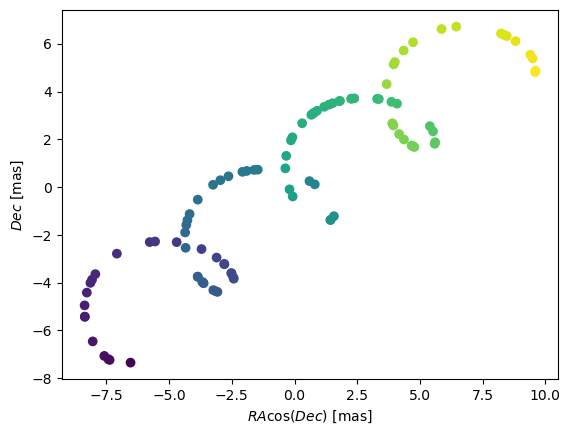

In [4]:
ax=plt.gca()
ax.scatter(racs,decs,c=ts)
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
#plt.savefig('docs/plots/singleBody.png')
plt.show()

In [5]:
# binary parameters
# (for single stars leave these blank or set l=q)
params.period=2      #[yr]
params.a=2    #[AU]
params.e=0.5
params.q=0.5
params.l=0.1
# viewing angle
params.vphi=4.5   #[rad]
params.vtheta=1.5 #[rad]
params.vomega=5.6 #[rad]
# time of some periapse passage
params.tperi=2016 #[jyear]

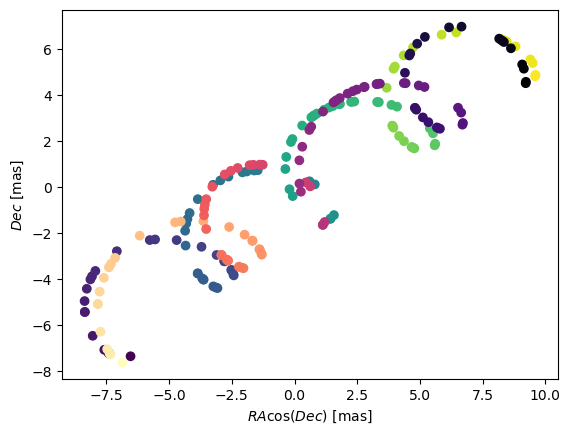

In [6]:
bracs,bdecs=astromet.track(ts,params)

ax=plt.gca()
ax.scatter(racs,decs,c=ts)
ax.scatter(bracs,bdecs,c=ts,cmap='magma_r')
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
#plt.savefig('docs/plots/twoBody.png')
plt.show()

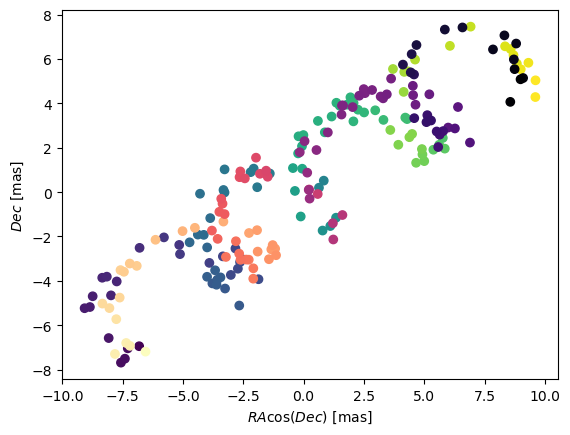

In [7]:
ast_error=0.3 # [mas]

obsracs=racs+ast_error*np.random.randn(ts.size)
obsdecs=decs+ast_error*np.random.randn(ts.size)

bobsracs=bracs+ast_error*np.random.randn(ts.size)
bobsdecs=bdecs+ast_error*np.random.randn(ts.size)

ax=plt.gca()
ax.scatter(obsracs,obsdecs,c=ts)
ax.scatter(bobsracs,bobsdecs,c=ts,cmap='magma_r')
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
#plt.savefig('docs/plots/twoBodyError.png')
plt.show()

In [8]:
results=astromet.simple_fit(ts,obsracs,obsdecs,ast_error,params.ra,params.dec)
print(results)

{'vis_periods': 70, 'n_obs': 100, 'drac': -0.01679273641238077, 'drac_error': 0.03321359833215772, 'ddec': -0.009243036406188319, 'ddec_error': 0.0331174430762243, 'drac_ddec_corr': -0.014905404162382205, 'parallax': 2.026416878130467, 'parallax_error': 0.03685068682651053, 'drac_parallax_corr': 0.13428201785757768, 'ddec_parallax_corr': -0.11100074604323566, 'pmrac': 4.056220534219314, 'pmrac_error': 0.02924681629101404, 'drac_pmrac_corr': -0.041964988592812294, 'ddec_pmrac_corr': 0.01076735987779045, 'parallax_pmrac_corr': -0.09700259017715503, 'pmdec': 2.998935251494912, 'pmdec_error': 0.02924352816087624, 'drac_pmdec_corr': -0.012870584186516168, 'ddec_pmdec_corr': -0.018387438062161397, 'parallax_pmdec_corr': -0.09584741420974908, 'pmrac_pmdec_corr': 0.009297447440128316, 'uwe': 1.0966205531563336, 'ra_ref': 160, 'dec_ref': -50}


In [9]:
bresults=astromet.simple_fit(ts,bobsracs,bobsdecs,ast_error,params.ra,params.dec)
print(bresults)

{'vis_periods': 70, 'n_obs': 100, 'drac': 0.6178464700343502, 'drac_error': 0.05130266715147668, 'ddec': 0.5495975691889164, 'ddec_error': 0.05115414301263801, 'drac_ddec_corr': -0.014905404162382209, 'parallax': 1.9707886745588947, 'parallax_error': 0.056920617322373614, 'drac_parallax_corr': 0.13428201785757765, 'ddec_parallax_corr': -0.11100074604323565, 'pmrac': 3.8927588792732895, 'pmrac_error': 0.04517546296588826, 'drac_pmrac_corr': -0.0419649885928123, 'ddec_pmrac_corr': 0.01076735987779045, 'parallax_pmrac_corr': -0.09700259017715504, 'pmdec': 2.963639721372018, 'pmdec_error': 0.04517038402670427, 'drac_pmdec_corr': -0.012870584186516166, 'ddec_pmdec_corr': -0.018387438062161397, 'parallax_pmdec_corr': -0.09584741420974908, 'pmrac_pmdec_corr': 0.009297447440128316, 'uwe': 1.693871247174582, 'ra_ref': 160, 'dec_ref': -50}


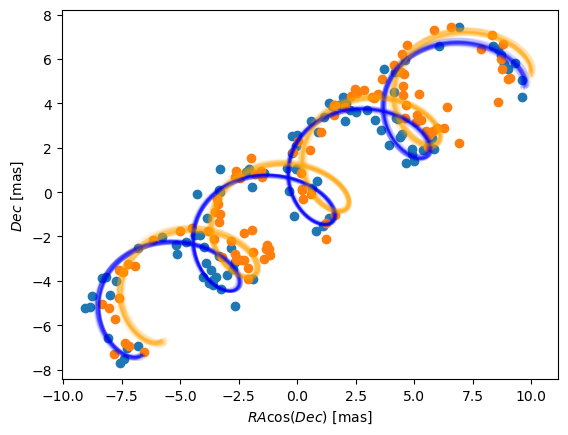

In [10]:
ax=plt.gca()
ax.scatter(obsracs,obsdecs)
ax.scatter(bobsracs,bobsdecs)

plotts=np.linspace(np.min(ts),np.max(ts),200)
fitparams=astromet.params()
bfitparams=astromet.params()
for i in range(32):
    fitparams.ra=160     #[deg]
    fitparams.dec=-50    #[deg]
    fitparams.drac=results['drac']+results['drac_error']*np.random.randn()     #[mas]
    fitparams.ddec=results['ddec']+results['ddec_error']*np.random.randn()     #[mas]
    fitparams.pmrac=results['pmrac']+results['pmrac_error']*np.random.randn()    #[mas/yr]
    fitparams.pmdec=results['pmdec']+results['pmdec_error']*np.random.randn()   #[mas/yr]
    fitparams.parallax=results['parallax']+results['parallax_error']*np.random.randn()     #[mas]

    fitracs,fitdecs=astromet.track(plotts,fitparams)
    ax.plot(fitracs,fitdecs,c='blue',alpha=0.1)

    bfitparams.ra=160     #[deg]
    bfitparams.dec=-50    #[deg]
    bfitparams.drac=bresults['drac']+bresults['drac_error']*np.random.randn()     #[mas]
    bfitparams.ddec=bresults['ddec']+bresults['ddec_error']*np.random.randn()     #[mas]
    bfitparams.pmrac=bresults['pmrac']+bresults['pmrac_error']*np.random.randn()    #[mas/yr]
    bfitparams.pmdec=bresults['pmdec']+bresults['pmdec_error']*np.random.randn()   #[mas/yr]
    bfitparams.parallax=bresults['parallax']+bresults['parallax_error']*np.random.randn()     #[mas]    

    bfitracs,bfitdecs=astromet.track(plotts,bfitparams)
    ax.plot(bfitracs,bfitdecs,c='orange',alpha=0.1)

ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
#plt.savefig('docs/plots/twoBodyFit.png')
plt.show()

In [11]:
import dev.astromet.astromet as astromet
import numpy as np
import matplotlib.pyplot as plt

ra=160
dec=-50

ts=np.sort(2016+(34/12)*np.random.rand(100))
phis=-180+360*np.random.rand(100)

# if scanning law can be used
import gaiascanlaw

ts,phis=gaiascanlaw.scanlaw(ra,dec)

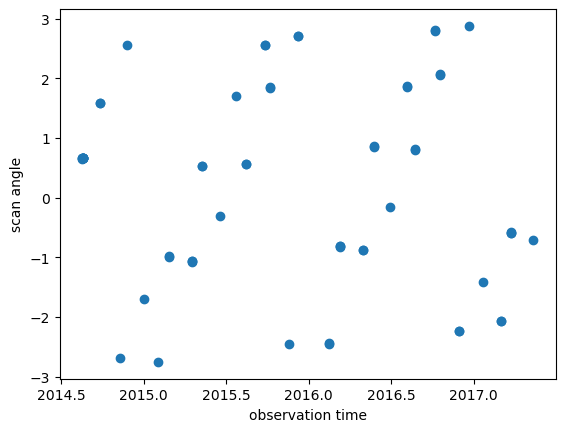

In [12]:
ax=plt.gca()
ax.scatter(ts,phis)
ax.set_xlabel(r'observation time [year]')
ax.set_ylabel(r'scan angle [rad]')
#plt.savefig('docs/plots/scanningLaw.png')
plt.show()

In [13]:
params=astromet.params()

params.ra=ra
params.dec=dec
params.drac=0
params.ddec=0
params.pmrac=8
params.pmdec=-2
params.parallax=5

params.period=2
params.a=2 
params.e=0.5
params.q=0.5
params.l=0.1

params.vphi=4.5
params.vtheta=1.5
params.vomega=5.6

params.tperi=2016

racs,decs=astromet.track(ts,params)

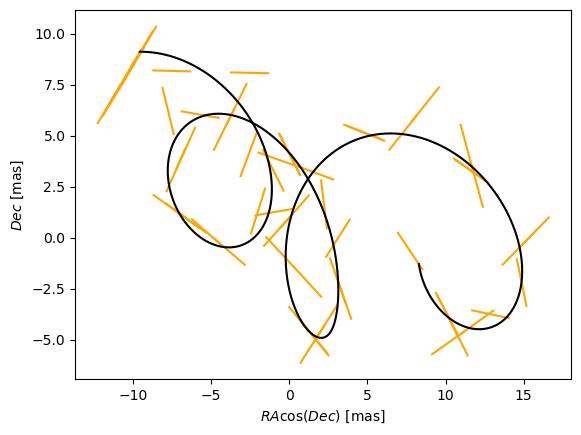

In [22]:
mag=18
al_error=astromet.sigma_ast(mag) # about 1.1 mas at this magnitude
errs=al_error*np.random.randn(phis.size)

obsracs=racs+errs*np.sin(phis)
obsdecs=decs+errs*np.cos(phis)

plotts=np.linspace(np.min(ts),np.max(ts),1000)
plotracs,plotdecs=astromet.track(plotts,params)

ax=plt.gca()
ax.plot([obsracs-al_error*np.sin(phis),obsracs+al_error*np.sin(phis)],
        [obsdecs-al_error*np.cos(phis),obsdecs+al_error*np.cos(phis)],c='orange')
ax.plot(plotracs,plotdecs,c='k')
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
#plt.savefig('docs/plots/twoBodyScans')
plt.show()

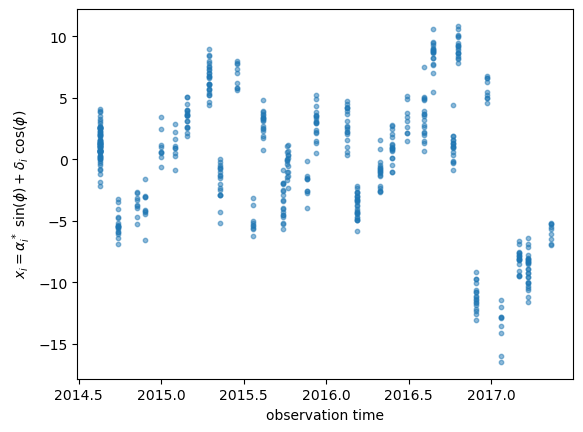

In [23]:
t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,racs,decs,err=al_error)

ax=plt.gca()
ax.scatter(t_obs,x_obs,s=10,alpha=0.5)
ax.set_xlabel(r'observation time')
ax.set_ylabel(r'$x_i = \alpha^*_i\ \sin(\phi) + \delta_i\ \cos(\phi)$')
#plt.savefig('docs/plots/scanXs.png')
plt.show()

In [24]:
bresults=astromet.fit(t_obs,x_obs,phi_obs,al_error,ra,dec)
print(bresults)
gresults=astromet.gaia_fit(t_obs,x_obs,phi_obs,al_error,ra,dec)
print(gresults)

{'vis_periods': 30, 'n_obs': 549, 'params_solved': 5, 'drac': 2.025003875979094, 'drac_error': 0.08469685698729981, 'ddec': 1.5571564587156208, 'ddec_error': 0.08512259494219308, 'drac_ddec_corr': 0.0847654990588848, 'parallax': 5.087661134879971, 'parallax_error': 0.11570887590434237, 'drac_parallax_corr': -0.1510340121555237, 'ddec_parallax_corr': -0.0822544286197156, 'pmrac': 7.789632313114572, 'pmrac_error': 0.09914955347642129, 'drac_pmrac_corr': 0.05140507856724145, 'ddec_pmrac_corr': 0.2184228555676954, 'parallax_pmrac_corr': 0.18323774541453114, 'pmdec': -2.0275081721450507, 'pmdec_error': 0.09842285062882011, 'drac_pmdec_corr': 0.2084027295366367, 'ddec_pmdec_corr': 0.10635217247934525, 'parallax_pmdec_corr': 0.18558977591553705, 'pmrac_pmdec_corr': -0.12827157333579864, 'excess_noise': 0.5939101287281577, 'chi2': 807.18093414306, 'n_good_obs': 549, 'uwe': 1.2181085673619674, 'ra_ref': 160, 'dec_ref': -50}
{'astrometric_matched_transits': 61, 'visibility_periods_used': 30, 'as

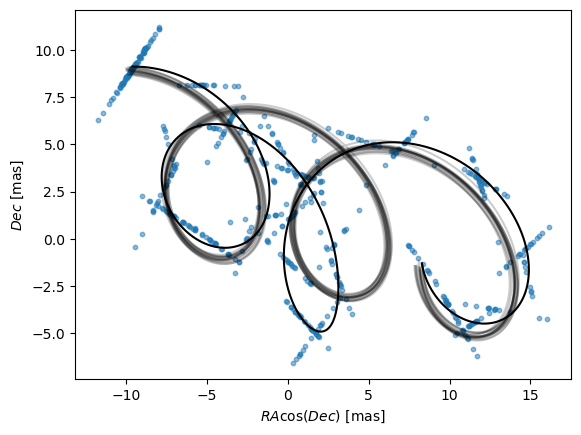

In [26]:
ax=plt.gca()
for i in range(16): # plotting 16 random realizations of the fit including error
    plotts=np.linspace(np.min(ts),np.max(ts),1000)
    
    fit_params=astromet.params()
    fit_params.ra=bresults['ra_ref']
    fit_params.dec=bresults['dec_ref']
    fit_params.drac=bresults['drac']+np.random.randn()*bresults['drac_error']
    fit_params.ddec=bresults['ddec']+np.random.randn()*bresults['ddec_error']
    fit_params.pmrac=bresults['pmrac']+np.random.randn()*bresults['pmrac_error']
    fit_params.pmdec=bresults['pmdec']+np.random.randn()*bresults['pmdec_error']
    fit_params.parallax=bresults['parallax']+np.random.randn()*bresults['parallax_error']
    
    fitracs,fitdecs=astromet.track(plotts,fit_params)
    ax.plot(fitracs,fitdecs,c='k',alpha=0.2)

# plotting the actual Gaia-like observations
ax.scatter(rac_obs,dec_obs,s=10,alpha=0.5)
ax.plot(plotracs,plotdecs,c='k')
    
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
#plt.savefig('docs/plots/gaiaFit.png')
plt.show()